## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image

## Load the data

In [2]:
transform = transforms.Compose([
    transforms.Resize(128),  # Resize the shorter side to 128
    transforms.CenterCrop(128),  # Crop to 128x128 from center
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),  # Normalize to [-1, 1]
])

data = datasets.CelebA('./data', split='train', download=False, transform=transform)

## Define the model

In [23]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features_d=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(in_channels, features_d, kernel_size=4, stride=2, padding=1),  # 128x128 -> 64x64
            nn.LeakyReLU(0.2),
            nn.Conv2d(features_d, features_d * 2, kernel_size=4, stride=2, padding=1),  # 64x64 -> 32x32
            nn.BatchNorm2d(features_d * 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(features_d * 2, features_d * 4, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.BatchNorm2d(features_d * 4),
            nn.LeakyReLU(0.2),
            nn.Conv2d(features_d * 4, features_d * 8, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            nn.BatchNorm2d(features_d * 8),
            nn.LeakyReLU(0.2),
            nn.Conv2d(features_d * 8, features_d * 16, kernel_size=4, stride=2, padding=1),  # 8x8 -> 4x4
            nn.BatchNorm2d(features_d * 16),
            nn.LeakyReLU(0.2),
            nn.Conv2d(features_d * 16, 1, kernel_size=4, stride=1, padding=0),  # 4x4 -> 1x1 (output real/fake)
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.disc(x)

In [24]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, out_channels=3, features_g=64):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(z_dim, features_g * 16, kernel_size=4, stride=1, padding=0),  # 1x1 -> 4x4
            nn.BatchNorm2d(features_g * 16),
            nn.ReLU(),
            nn.ConvTranspose2d(features_g * 16, features_g * 8, kernel_size=4, stride=2, padding=1),  # 4x4 -> 8x8
            nn.BatchNorm2d(features_g * 8),
            nn.ReLU(),
            nn.ConvTranspose2d(features_g * 8, features_g * 4, kernel_size=4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.BatchNorm2d(features_g * 4),
            nn.ReLU(),
            nn.ConvTranspose2d(features_g * 4, features_g * 2, kernel_size=4, stride=2, padding=1),  # 16x16 -> 32x32
            nn.BatchNorm2d(features_g * 2),
            nn.ReLU(),
            nn.ConvTranspose2d(features_g * 2, features_g, kernel_size=4, stride=2, padding=1),  # 32x32 -> 64x64
            nn.BatchNorm2d(features_g),
            nn.ReLU(),
            nn.ConvTranspose2d(features_g, out_channels, kernel_size=4, stride=2, padding=1),  # 64x64 -> 128x128
            nn.Tanh()  # output normalized between [-1, 1]
        )

    def forward(self, x):
        return self.gen(x)

## Define the Loss function and Hyperparameters

In [25]:
# Hyperparameters
EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 0.0002
Z_DIM = 100 
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
K_STEPS = 1

In [26]:
# Loss function
loss_fn = nn.BCELoss()

In [27]:
# Create the models
generator = Generator(z_dim=Z_DIM, out_channels=3).to(DEVICE)
discriminator = Discriminator(in_channels=3).to(DEVICE)

In [28]:
# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

In [29]:
# DataLoader
dataloader = torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, shuffle=True)

In [30]:
# Fixed noise for generating consistent sample images during training
fixed_noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(DEVICE)

## Define training procedure

In [31]:
# Training loop with tqdm
for epoch in range(EPOCHS):
    loop = tqdm(dataloader, leave=True)  # tqdm for progress tracking
    for batch_idx, (real, _) in enumerate(loop):
        real = real.to(DEVICE)
        m = real.size(0)  # Get batch size

        ### Train the Discriminator: maximize log(D(x)) + log(1 - D(G(z))) ###
        for _ in range(K_STEPS):
            noise = torch.randn(m, Z_DIM, 1, 1).to(DEVICE)  # Generate latent vectors from N(0, 1)
            fake = generator(noise)  # Generate fake images

            # Discriminator loss on real and fake images
            disc_real = discriminator(real).view(-1)
            loss_d_real = loss_fn(disc_real, torch.ones_like(disc_real))  # Label real images as 1

            disc_fake = discriminator(fake.detach()).view(-1)
            loss_d_fake = loss_fn(disc_fake, torch.zeros_like(disc_fake))  # Label fake images as 0

            loss_d = (loss_d_real + loss_d_fake) / 2  # Total loss for the discriminator

            optimizer_d.zero_grad()
            loss_d.backward()  # Backpropagate
            optimizer_d.step()  # Update discriminator weights

        ### Train the Generator: maximize log(D(G(z))) ###
        noise = torch.randn(m, Z_DIM, 1, 1).to(DEVICE)
        fake = generator(noise)  # Generate new fake images

        disc_fake = discriminator(fake).view(-1)
        loss_g = loss_fn(disc_fake, torch.ones_like(disc_fake))  # We want the discriminator to predict 1 for fake images

        optimizer_g.zero_grad()
        loss_g.backward()  # Backpropagate
        optimizer_g.step()  # Update generator weights

        # Update tqdm description
        loop.set_description(f'Epoch [{epoch}/{EPOCHS}]')
        loop.set_postfix(loss_d=loss_d.item(), loss_g=loss_g.item())

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [64, 3, 4, 4], expected input[32, 1, 28, 28] to have 3 channels, but got 1 channels instead

## Generate image

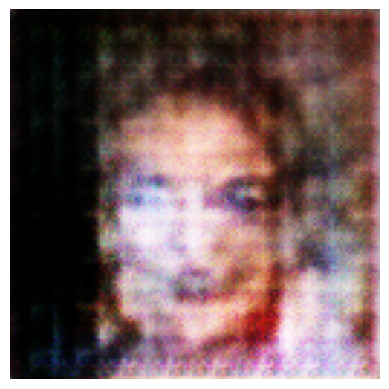

In [16]:
# Function to generate an image
def generate_image(generator, z_dim=100, device='cuda'):
    # Set the generator in evaluation mode
    generator.eval()
    
    # Generate a random latent vector
    noise = torch.randn(1, z_dim, 1, 1).to(device)  # 1 sample, Z_DIM size latent vector
    
    # Generate a fake image from the latent vector
    with torch.no_grad():  # No need to track gradients during inference
        fake_image = generator(noise)
    
    # Convert the output tensor to a format suitable for visualization
    fake_image = (fake_image * 0.5) + 0.5  # Rescale from [-1, 1] to [0, 1]
    
    # Plot the generated image
    plt.imshow(fake_image.squeeze(0).permute(1, 2, 0).cpu().numpy())  # Convert from (C, H, W) to (H, W, C)
    plt.axis('off')  # Turn off axis for better visual display
    plt.show()

# Assuming the generator is already trained and available
generate_image(generator)

## For MNIST

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
data = datasets.MNIST('../VAE_MNIST/data', train=True, download=False, transform=transform)

$$
Output Shape = (\frac{(n + 2p - f)}{s} + 1) \times (\frac{(n + 2p - f)}{s} + 1)
$$

n = Input size  
p = padding  
f = kernel size  
s = stride

In [3]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=1, features_d=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(in_channels, features_d, kernel_size=3, stride=2, padding=1),  # 28x28 -> 14x14
            nn.BatchNorm2d(features_d),
            nn.LeakyReLU(0.2),
            nn.Conv2d(features_d, features_d * 2, kernel_size=3, stride=2, padding=1),  # 14x14 -> 7x7
            nn.BatchNorm2d(features_d * 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(features_d * 2, features_d * 4, kernel_size=3, stride=2, padding=0),  # 7x7 -> 3x3
            nn.BatchNorm2d(features_d * 4),
            nn.LeakyReLU(0.2),
            nn.Conv2d(features_d * 4, 1, kernel_size=3, stride=1, padding=0),  # 3x3 -> 1x1
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.disc(x)

$$
          H_{out} = (H_{in} - 1) \times \text{stride}[0] - 2 \times \text{padding}[0] + \text{dilation}[0]
                    \times (\text{kernel\_size}[0] - 1) + \text{output\_padding}[0] + 1
$$

$$
         W_{out} = (W_{in} - 1) \times \text{stride}[1] - 2 \times \text{padding}[1] + \text{dilation}[1]
                    \times (\text{kernel\_size}[1] - 1) + \text{output\_padding}[1] + 1
$$

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, out_channels=1, features_g=16):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(z_dim, features_g * 4, kernel_size=3, stride=2, output_padding=0),  # 1x1 -> 3x3
            nn.BatchNorm2d(features_g * 4),
            nn.ReLU(),
            nn.ConvTranspose2d(features_g * 4, features_g * 2, kernel_size=3, stride=2, output_padding=0),  # 3x3 -> 7x7
            nn.BatchNorm2d(features_g * 2),
            nn.ReLU(),
            nn.ConvTranspose2d(features_g * 2, features_g, kernel_size=3, stride=2, padding=1, output_padding=1),  # 7x7 -> 14x14
            nn.BatchNorm2d(features_g),
            nn.ReLU(),
            nn.ConvTranspose2d(features_g, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),  # 14x14 -> 28x28
            nn.Tanh()  # output normalized between [-1, 1]
        )

    def forward(self, x):
        return self.gen(x)

In [5]:
# Hyperparameters
EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 0.0002
Z_DIM = 100 
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
K_STEPS = 1

# Loss function
loss_fn = nn.BCELoss()

# Create the models
generator = Generator(z_dim=Z_DIM, out_channels=1).to(DEVICE)
discriminator = Discriminator(in_channels=1).to(DEVICE)

# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

# DataLoader
dataloader = torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, shuffle=True)

# Fixed noise for generating consistent sample images during training
fixed_noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(DEVICE)

In [7]:
# Training loop with tqdm
for epoch in range(EPOCHS):
    loop = tqdm(dataloader, leave=True)  # tqdm for progress tracking
    for batch_idx, (real, _) in enumerate(loop):
        real = real.to(DEVICE)
        m = real.size(0)  # Get batch size

        ### Train the Discriminator: maximize log(D(x)) + log(1 - D(G(z))) ###
        for _ in range(K_STEPS):
            noise = torch.randn(m, Z_DIM, 1, 1).to(DEVICE)  # Generate latent vectors from N(0, 1)
            fake = generator(noise)  # Generate fake images

            # Discriminator loss on real and fake images
            disc_real = discriminator(real).view(-1)
            loss_d_real = loss_fn(disc_real, torch.ones_like(disc_real))  # Label real images as 1

            disc_fake = discriminator(fake.detach()).view(-1)
            loss_d_fake = loss_fn(disc_fake, torch.zeros_like(disc_fake))  # Label fake images as 0

            loss_d = (loss_d_real + loss_d_fake) / 2  # Total loss for the discriminator

            optimizer_d.zero_grad()
            loss_d.backward()  # Backpropagate
            optimizer_d.step()  # Update discriminator weights

        ### Train the Generator: maximize log(D(G(z))) ###
        noise = torch.randn(m, Z_DIM, 1, 1).to(DEVICE)
        fake = generator(noise)  # Generate new fake images

        disc_fake = discriminator(fake).view(-1)
        loss_g = loss_fn(disc_fake, torch.ones_like(disc_fake))  # We want the discriminator to predict 1 for fake images

        optimizer_g.zero_grad()
        loss_g.backward()  # Backpropagate
        optimizer_g.step()  # Update generator weights

        # Update tqdm description
        loop.set_description(f'Epoch [{epoch}/{EPOCHS}]')
        loop.set_postfix(loss_d=loss_d.item(), loss_g=loss_g.item())

Epoch [9/10]: 100%|██████████| 1875/1875 [00:37<00:00, 50.26it/s, loss_d=0.0101, loss_g=7.61]  


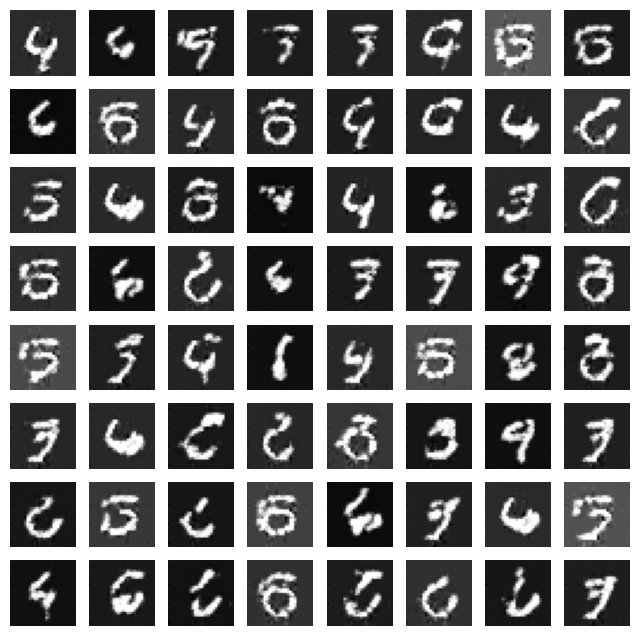

In [12]:
# Function to generate an image
def generate_image(generator, z_dim=100, device='cuda'):
    # Set the generator in evaluation mode
    generator.eval()
    
    # Generate a random latent vector
    noise = torch.randn(64, z_dim, 1, 1).to(device)  # 1 sample, Z_DIM size latent vector
    
    # Generate a fake image from the latent vector
    with torch.no_grad():  # No need to track gradients during inference
        fake_images = generator(noise)
    
    # Convert the output tensor to a format suitable for visualization
    fake_images = (fake_images * 0.5) + 0.5  # Rescale from [-1, 1] to [0, 1]
    
    fig, axes = plt.subplots(8, 8, figsize=(8, 8))
    for i in range(64):
        row, col = divmod(i, 8)
        axes[row, col].imshow(fake_images[i].permute(1, 2, 0).cpu().numpy(), cmap='gray') # Convert from (C, H, W) to (H, W, C)
        axes[row, col].axis('off')

    # Plot the generated image
    plt.show()

# Assuming the generator is already trained and available
generate_image(generator)